In [1]:
%pylab --no-import-all inline
import pandas as pd
import pandas.io.data as web
import numpy as np
import scipy.stats as stats
import scipy.signal as signal

import seaborn as sns
from collections import *
from operator import *
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import re
import string
import os
from dateutil import parser

import matplotlib.pyplot as plt

import zipline as zp
from zipline.finance import trading
from zipline.finance.trading import TradingEnvironment
from zipline.utils import tradingcalendar

import datetime
from datetime import datetime
from datetime import timedelta
import pytz

utc=pytz.UTC

matplotlib.style.available
matplotlib.style.use('fivethirtyeight')
sns.set_context("talk", font_scale=1.2)
sns.set_palette("Set1",10, .80)
matplotlib.style.use('bmh')
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['axes.facecolor'] = '0.99'
matplotlib.rcParams['figure.facecolor'] = '0.97'
figsize(18, 8)

indexTradingCal = pd.DatetimeIndex(tradingcalendar.trading_days)
indexTradingCal = indexTradingCal.normalize()

Populating the interactive namespace from numpy and matplotlib


In [17]:
SPY = web.get_data_yahoo('SPY', start='1/1/1970')
SPY = pd.DataFrame.rename(SPY, columns={'Adj Close': 'AdjClose'})
SPY.columns.name = "SPY"

AAPL = web.get_data_yahoo('AAPL', start='1/1/1970')
AAPL = pd.DataFrame.rename(AAPL, columns={'Adj Close': 'AdjClose'})
AAPL.columns.name = "AAPL"

IBM = web.get_data_yahoo('IBM', start='1/1/1970')
IBM = pd.DataFrame.rename(IBM, columns={'Adj Close': 'AdjClose'})
IBM.columns.name = "IBM"

GLD = web.get_data_yahoo('GLD', start='1/1/1970')
GLD = pd.DataFrame.rename(GLD, columns={'Adj Close': 'AdjClose'})
GLD.columns.name = "GLD"

SLV = web.get_data_yahoo('SLV', start='1/1/1970')
SLV = pd.DataFrame.rename(SLV, columns={'Adj Close': 'AdjClose'})
SLV.columns.name = "SLV"

USO = web.get_data_yahoo('USO', start='1/1/1970')
USO = pd.DataFrame.rename(USO, columns={'Adj Close': 'AdjClose'})
USO.columns.name = "USO"

TLT = web.get_data_yahoo('TLT', start='1/1/1970')
TLT = pd.DataFrame.rename(TLT, columns={'Adj Close': 'AdjClose'})
TLT.columns.name = "TLT"

GE = web.get_data_yahoo('GE', start='1/1/1970')
GE = pd.DataFrame.rename(GE, columns={'Adj Close': 'AdjClose'})
GE.columns.name = "GE"

XOM = web.get_data_yahoo('XOM', start='1/1/1970')
XOM = pd.DataFrame.rename(XOM, columns={'Adj Close': 'AdjClose'})
XOM.columns.name = "XOM"

SDS = web.get_data_yahoo('SDS', start='1/1/1970')
SDS = pd.DataFrame.rename(SDS, columns={'Adj Close': 'AdjClose'})
SDS.columns.name = "SDS"

QID = web.get_data_yahoo('QID', start='1/1/1970')
QID = pd.DataFrame.rename(QID, columns={'Adj Close': 'AdjClose'})
QID.columns.name = "QID"

# managed risk/risk parity mutual funds/ETFs
AQRNX = web.get_data_yahoo('AQRNX', start='1/1/1970')
AQRNX = pd.DataFrame.rename(AQRNX, columns={'Adj Close': 'AdjClose'})
AQRNX.columns.name = "AQRNX"

RORO = web.get_data_yahoo('RORO', start='1/1/1970')
RORO = pd.DataFrame.rename(RORO, columns={'Adj Close': 'AdjClose'})
RORO.columns.name = "RORO"

# Alt style ETF
   

#option funds/ETF
EXD = web.get_data_yahoo('EXD', start='1/1/1970')
EXD = pd.DataFrame.rename(EXD, columns={'Adj Close': 'AdjClose'})
EXD.columns.name = "EXD"

ETJ = web.get_data_yahoo('ETJ', start='1/1/1970')
ETJ = pd.DataFrame.rename(ETJ, columns={'Adj Close': 'AdjClose'})
ETJ.columns.name = "ETJ"

EOS = web.get_data_yahoo('EOS', start='1/1/1970')
EOS = pd.DataFrame.rename(EOS, columns={'Adj Close': 'AdjClose'})
EOS.columns.name = "EOS"

ETW = web.get_data_yahoo('ETW', start='1/1/1970')
ETW = pd.DataFrame.rename(ETW, columns={'Adj Close': 'AdjClose'})
ETW.columns.name = "ETW"

ETV = web.get_data_yahoo('ETV', start='1/1/1970')
ETV = pd.DataFrame.rename(ETV, columns={'Adj Close': 'AdjClose'})
ETV.columns.name = "ETV"

ERW = web.get_data_yahoo('ERW', start='1/1/1970')
ERW = pd.DataFrame.rename(ERW, columns={'Adj Close': 'AdjClose'})
ERW.columns.name = "ERW"

ETB = web.get_data_yahoo('ETB', start='1/1/1970')
ETB = pd.DataFrame.rename(ETB, columns={'Adj Close': 'AdjClose'})
ETB.columns.name = "ETB"

In [26]:
testStocksDict = {'SPY':SPY.AdjClose, 'AAPL':AAPL.AdjClose, 'IBM':IBM.AdjClose, 'XOM':XOM.AdjClose, 'GE':GE.AdjClose,
                  'GLD':GLD.AdjClose, 'SLV':SLV.AdjClose, 'USO':USO.AdjClose,
                  'SDS':SDS.AdjClose, 'QID':QID.AdjClose }

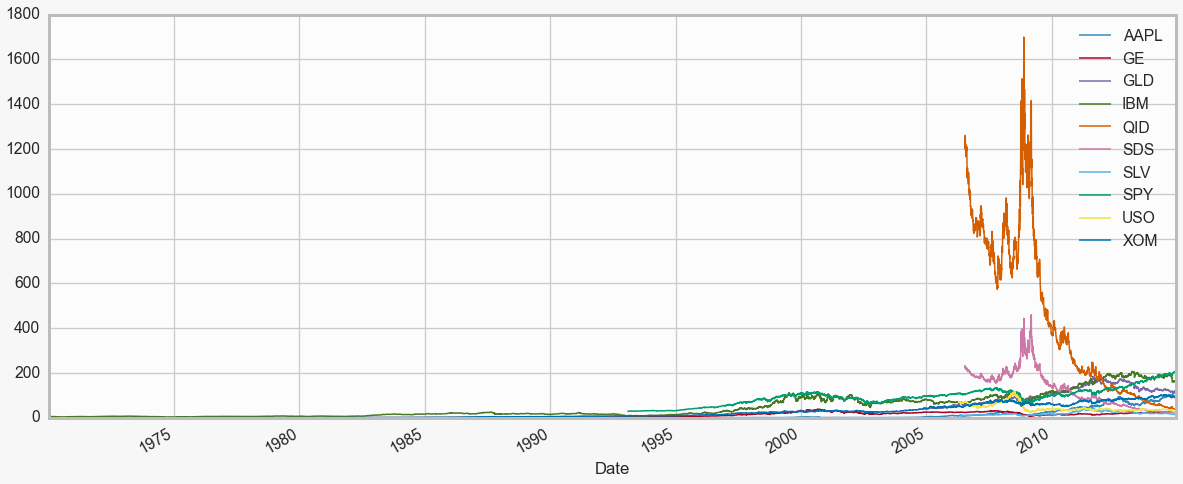

In [28]:
pd.DataFrame(testStocksDict).plot()

In [3]:
def normalize(df, withStartingValue=1):
    if withStartingValue > 1:
        return withStartingValue * ( df / df.iloc[0] )
    else:
        return df / df.iloc[0]

def cum_returns(df, withStartingValue=None):
    if withStartingValue is None:
        return (1 + df).cumprod() - 1
    else:
        return (1 + df).cumprod() * withStartingValue
    
def detrendTS(theTS):
    return pd.Series(data=signal.detrend(theTS.values),index=theTS.index.values)


In [7]:
def maxDrawdown(ts):
    MDD = 0
    DD = 0
    peak = -99999
    for value in ts:
        if (value > peak):
            peak = value
        else:
            DD = (peak - value) / peak
        if (DD > MDD):
            MDD = DD
    return -1*MDD

def annualReturn(ts, inputIsNAV=True):
    if inputIsNAV:
        tempReturns = ts.pct_change().dropna()
        return tempReturns.mean() * 252
    else:
        return ts.mean() * 252


def annualVolatility(ts, inputIsNAV=True):
    if inputIsNAV:
        tempReturns = ts.pct_change().dropna()
        return tempReturns.std() * np.sqrt(252)
    else:
        return ts.std() * np.sqrt(252)


def sharpeRatio(ts, inputIsNAV=True):
    if inputIsNAV:
        tempReturns = ts.pct_change().dropna()
        return (tempReturns.mean() / tempReturns.std()) * (np.sqrt(252))
    else:
        return (ts.mean() / ts.std()) * (np.sqrt(252))

def stabilityOfTimeseries( ts, logValue=True ):
    tsLen = ts.size
    X = range(0, tsLen)
    X = sm.add_constant(X)
    if logValue:
        tempValues = np.log10(ts.values)
    else:
        tempValues = ts.values
    model = sm.OLS( tempValues, X ).fit()
    
    return model.rsquared

def betaTimeseries( theTS, benchmarkTS=SPY.AdjClose, inputIsReturns=False):
    tempTS = theTS.copy()
    tempBench = benchmarkTS.copy()
    
    tempTS = tempTS.asfreq(freq='D',normalize=True)
    tempBench = tempBench.asfreq(freq='D',normalize=True)
    
    if not inputIsReturns:
        tempTS = tempTS.pct_change().dropna()
        tempBench = tempBench.pct_change().dropna()
    
    tempTS = tempTS[ np.isfinite(tempTS) ]
    tempBench = tempBench[ np.isfinite(tempBench) ]
    
    # remove intraday timestamps by normalizing since only working with daily data right now
    # tempTS.reindex(tempTS.index.normalize())
    # tempBench.reindex(tempBench.index.normalize())
    
    # tempTS.reindex(indexTradingCal)
    # tempBench.reindex(indexTradingCal)
    
    tempAlign = tempBench.align(tempTS,join='inner')
    alignBench = tempAlign[0]
    alignTS = tempAlign[1]
    # print( alignBench.head() )
    # print( alignTS.head() )
    regX = np.array( alignBench.values )
    regY = np.array( alignTS.values )
    
    regX = np.reshape(regX,len(regX))
    regY = np.reshape(regY,len(regY))
    
    m, b = np.polyfit(regX, regY, 1) 
    
    return m 

def hurst(ts, lagsToTest=20):  
    tau = []
    lagvec = []  
    #  Step through the different lags  
    for lag in range(2,lagsToTest):  
        #  produce price difference with lag  
        pp = np.subtract(ts[lag:],ts[:-lag])  
        #  Write the different lags into a vector  
        lagvec.append(lag)  
        #  Calculate the variance of the differnce vector  
        tau.append(np.sqrt(np.std(pp)))  
    #  linear fit to double-log graph (gives power)  
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)  
    # calculate hurst  
    hurst = m[0]*2  
    # plot lag vs variance  
    #py.plot(lagvec,tau,'o'); show()  
    return hurst 

def halfLife(ts):
    
    price = pd.Series(ts)  
    lagged_price = price.shift(1).fillna(method="bfill")  
    delta = price - lagged_price  
    beta = np.polyfit(lagged_price, delta, 1)[0] 
    half_life = (-1*np.log(2)/beta) 
    
    return half_life

def out_of_sample_vs_in_sample_P(ts, in_sample_length) :
    total_length = len(ts)
    short_long_diff = total_length - in_sample_length
    
   # in_sample_list = [ x-ts[0] for x in ts[0:short_long_diff] ]
   # out_of_sample_list = [ x-ts[short_long_diff] for x in ts[short_long_diff:total_length] ]
    
    in_sample_list = [ x for x in ts[0:short_long_diff] ]
    out_of_sample_list = [ x for x in ts[short_long_diff:total_length] ]
    
    tempP = stats.ttest_ind(in_sample_list, out_of_sample_list, equal_var = False)[1]
    
    return tempP

def out_of_sample_vs_in_sample_P_rolling(ts, in_sample_length, rolling_length) :
    test_rolling_ttest = [ (ts.index[i+rolling_length] , 
                            out_of_sample_vs_in_sample_P(ts[i:i+rolling_length], in_sample_length) ) 
                          for i in range(0, len(ts)-rolling_length,rolling_length) ]
    tempDF = pd.DataFrame(test_rolling_ttest)
    tempDF.index = tempDF[0]
    tempDF.index.name = 'Date'
    tempDF = tempDF.drop(0,1)
    tempDF.columns = ['pvalue']
    
    return tempDF


pvalue    0.45323
dtype: float64


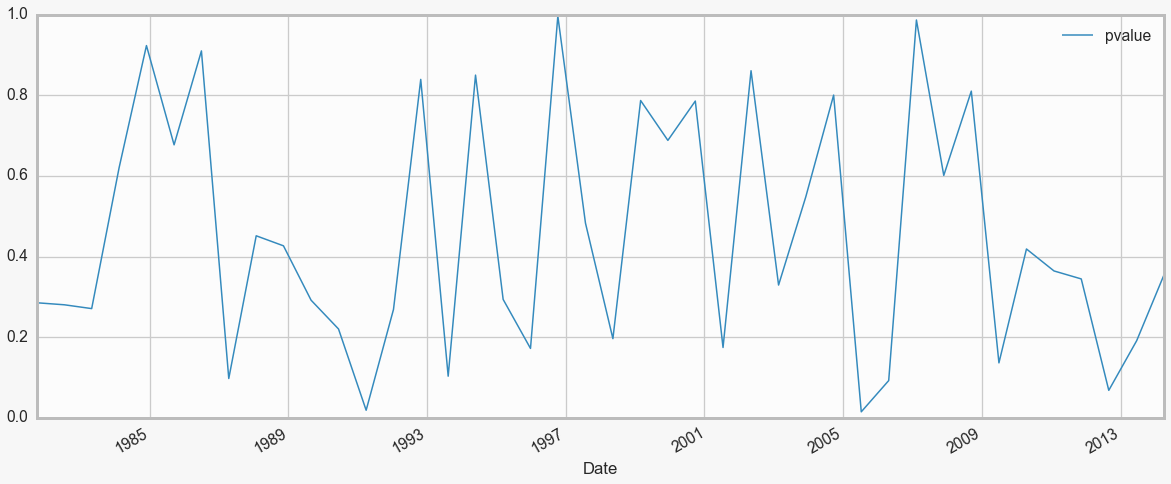

In [8]:
out_of_sample_vs_in_sample_P_rolling(AAPL.AdjClose.pct_change().dropna(), 100, 200).plot()
print( np.mean(out_of_sample_vs_in_sample_P_rolling(AAPL.AdjClose.pct_change().dropna(), 100, 200)) )

In [9]:
stats.ttest_ind([30.02,29.99,30.11,29.97,30.01,29.99], [29.89,29.93,29.72,29.98,30.02,29.98], equal_var = False)

(1.9590058081081434, 0.090773324285661136)

In [10]:
# compared to the above, when assuming that each sample was pulled from populations with equal variance,
# the below is somewhat more suggestive of a difference in the mean weights for the two samples used as inputs to the t-test
stats.ttest_ind([30.02,29.99,30.11,29.97,30.01,29.99], [29.89,29.93,29.72,29.98,30.02,29.98], equal_var = True)

(1.9590058081081436, 0.078565773857230708)

In [11]:
print np.mean([2,3,5,6,4,2,2,2,2])
print np.mean([2,2,2,2,2,6,3,4,5])

3.11111111111
3.11111111111


In [12]:
stats.ttest_ind([2,3,5,6,4,2,2,2,2], [2,2,2,2,2,6,3,4,5], equal_var = True)

(0.0, 1.0)

In [13]:
halfLife(detrendTS(SPY.Close))

524.09408331892405

In [14]:
def plotHeatmap(df, titleStr='', cmap=pyplot.cm.RdYlGn):
    """
    This creates our heatmap using our sharpe ratio dataframe
    """
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation = 'nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    ax.set_title(titleStr)
    pyplot.colorbar(axim)
    
def plotScatter(x1Values, y1Values, 
                moreXvaluesList=None, moreYvaluesList=None, 
                autoLabelValues1=False, autoLabelMoreValues=False,
                autoLabelMoreValuesIndexes = [0],
                plotTitle=None,
                xAxisLabel=None, yAxisLabel=None,
                showLegend=True,
                legendLocation='upper left',
                legendLabel1='series1',
                legendLabelMoreList=None,
                showRegressionLine=True,
                seriesToUseForRegression=1,
                colorOrder = ['blue','yellow','red','black','pink','gray','orange','purple','darkred','darkblue'],
                transparency=0.7):
    
    x = np.array(x1Values)
    y = np.array(y1Values)
    x = np.reshape(x,len(x))
    y = np.reshape(y,len(y))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    pointColor = 1
    
    ax1.scatter(x, y, s=200, color=colorOrder[0], alpha=transparency, marker="o", label=legendLabel1)
    if autoLabelValues1:
        for i in range(x.size):
            ax1.annotate( str(i), xy=(x[i]*1.01, y[i]*1.01), size=20 )
    
    if (moreXvaluesList is not None) and (moreYvaluesList is not None):
        count = 0
        for xyTemp in zip(moreXvaluesList, moreYvaluesList): 
            xTemp = np.array(xyTemp[0])
            yTemp = np.array(xyTemp[1])
            xTemp = np.reshape(xTemp,len(xTemp))
            yTemp = np.reshape(yTemp,len(yTemp))
            if legendLabelMoreList is None:
                tempLegendLabel = 'series' + str(count+2)
            else:
                tempLegendLabel = legendLabelMoreList[count]
            ax1.scatter(xTemp, yTemp, color=colorOrder[pointColor], alpha=transparency, s=200, marker="o", label=tempLegendLabel)
            pointColor += 1
            if autoLabelMoreValues:
                if count in autoLabelMoreValuesIndexes:
                    for i in range(xTemp.size):
                        ax1.annotate( str(i), xy=( xTemp[i]*1.01, yTemp[i]*1.01 ), size=20 )
            count += 1
            
    if showRegressionLine:
        if seriesToUseForRegression == 1:
            regX = x
            regY = y
        else:
            regX = np.array( moreXvaluesList[seriesToUseForRegression-2] )
            regY = np.array( moreYvaluesList[seriesToUseForRegression-2] )
            regX = np.reshape(regX,len(regX))
            regY = np.reshape(regY,len(regY))
        m, b = np.polyfit(regX, regY, 1)
        ax1.plot(regX, m*regX + b, '-', color=colorOrder[seriesToUseForRegression-1], alpha=transparency) 
     
    if plotTitle is not None:
        plt.title(plotTitle)
    if showLegend:
        plt.legend(loc=legendLocation)
    if xAxisLabel is not None:
        plt.xlabel(xAxisLabel)
    if yAxisLabel is not None:
        plt.ylabel(yAxisLabel)
    plt.show()

In [31]:
def dfTS(df, dateColumnLabel='Date'):
    # e.g.: takes a dataframe from a yahoo finance price csv and returns a df with datetime64 index
    colNames = df.columns
    tempDF = df.copy()
    indexDates = map(np.datetime64, df.ix[:,dateColumnLabel].values)   
    # tempDF = pd.DataFrame(data=df.values , index=map(pd.to_datetime, indexDates))
    tempDF = pd.DataFrame(data=df.values , index=indexDates)
    tempDF.columns = colNames
    
    return tempDF.drop(axis=1,labels=dateColumnLabel).sort_index()

def appendSeries( ts1, ts2 ):
    return pd.Series( data=np.concatenate([ts1,ts2]) , index=np.concatenate([ts1.index,ts2.index]) )

def multiTimeseriesToDF_fromDict( tsDictInput, asPctChange=False, startDate=None, endDate=None,
                        dropNA=False, ffillNA=False, fillNAvalue=None ):
    tempDict = {}
    
    for i in tsDictInput.keys():
        if asPctChange:
            # print(i)
            # print(tsDictInput.get(i).head())
            tempDict[ i ] = sliceTS(tsDictInput.get(i).pct_change().dropna(), startDate=startDate, endDate=endDate)
        else:
            tempDict[ i ] = sliceTS(tsDictInput.get(i), startDate=startDate, endDate=endDate)
    tempDF = pd.DataFrame(tempDict)
    if dropNA:
        tempDF = tempDF.dropna()
    elif ffillNA:
        tempDF = tempDF.fillna(method="ffill") 
    elif fillNAvalue is not None:
        tempDF = tempDF.fillna(fillNAvalue)
        
    return tempDF

def multiTimeseriesToDF( tsSeriesList, tsSeriesNamesArr, asPctChange=False, startDate=None, endDate=None,
                        dropNA=False, ffillNA=False, fillNAvalue=None ):
    tempDict = {}
    
    for i in range(0,len(tsSeriesNamesArr)):
        if asPctChange:
            tempDict[ tsSeriesNamesArr[i] ] = sliceTS(tsSeriesList[i].pct_change().dropna(), startDate=startDate, endDate=endDate)
        else:
            tempDict[ tsSeriesNamesArr[i] ] = tsSeriesList[i]
    tempDF = pd.DataFrame(tempDict)
    if dropNA:
        tempDF = tempDF.dropna()
    elif ffillNA:
        tempDF = tempDF.fillna(method="ffill") 
    elif fillNAvalue is not None:
        tempDF = tempDF.fillna(fillNAvalue)
        
    return tempDF

def sliceTS(theTS, startDate=None, endDate=None):
    if (startDate is None) and (endDate is None):
        return theTS
    elif startDate is None:
        return theTS[ theTS.index < endDate ]
    elif endDate is None:
        return theTS[ theTS.index > startDate ]
    else:
        return theTS[ (theTS.index > startDate) & (theTS.index < endDate) ]
    
def compareTS( tsDict ):
    return normalize(multiTimeseriesToDF_fromDict( tsDict,dropNA=True))


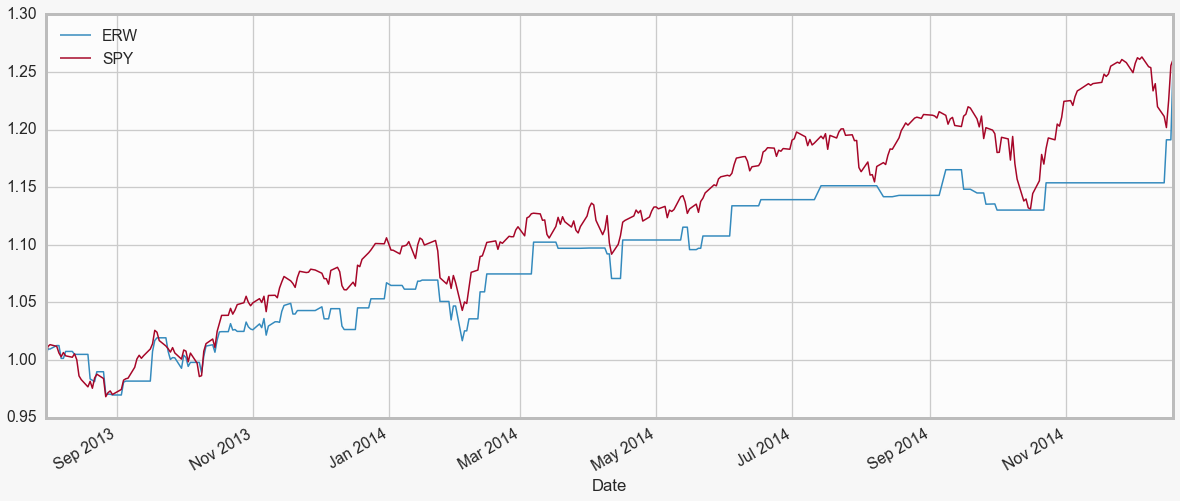

In [33]:
compareTS( {'ERW':ERW.AdjClose, 'SPY':SPY.AdjClose }).plot()

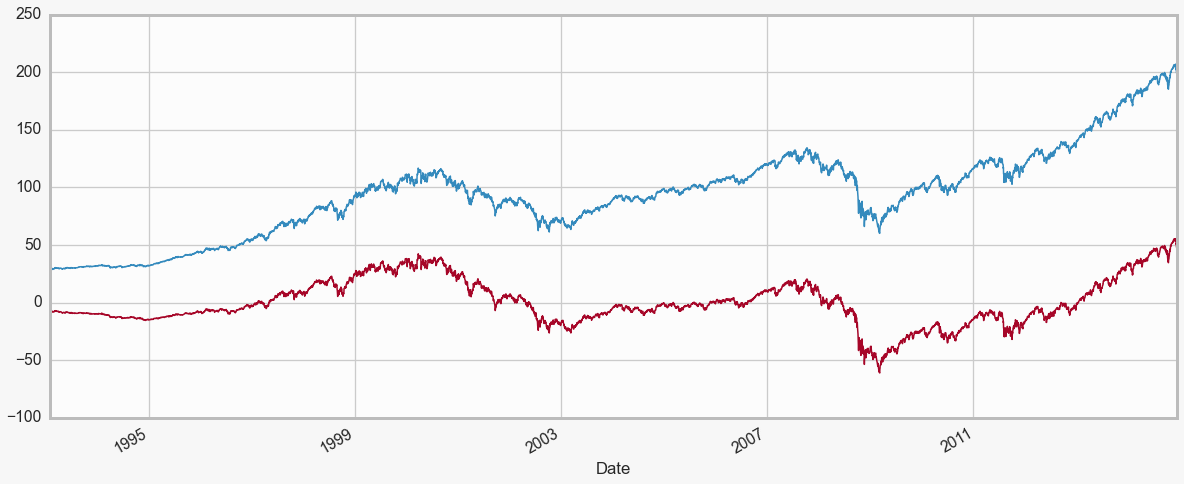

In [35]:
SPY.AdjClose.plot()
pd.Series(data=signal.detrend(SPY.AdjClose.values), index=SPY.AdjClose.index.values).plot()

In [36]:
tempADF = ts.adfuller(signal.detrend(SPY.AdjClose.values), regression='ct', autolag=None, maxlag=1, store=True)

In [37]:
tempADFrs = tempADF[3]

In [38]:
tempADFrs.adfstat

-1.0362228677616785

In [38]:
ts.adfuller(signal.detrend(SPY.AdjClose.values), regression='ct', autolag=None, maxlag=1)

(-1.0325872460535628,
 0.93956601182871469,
 1,
 5504,
 {'1%': -3.9604157611554074,
  '10%': -3.1275198971396243,
  '5%': -3.4112879729674606})

In [35]:
ts.adfuller(SPY.AdjClose.values, regression='ct', autolag=None, maxlag=1)

(-1.0325872460552414,
 0.93956601182847188,
 1,
 5504,
 {'1%': -3.9604157611554074,
  '10%': -3.1275198971396243,
  '5%': -3.4112879729674606})

In [39]:
ts.adfuller(signal.detrend(SPY.AdjClose.values), regression='c', autolag=None, maxlag=1)

(-1.0341961560313702,
 0.74058866410675295,
 1,
 5504,
 {'1%': -3.4315386541431767,
  '10%': -2.5670495985385364,
  '5%': -2.8620652671839455})

In [40]:
ts.adfuller((SPY.AdjClose - AAPL.AdjClose).dropna().values, regression='ct', autolag=None, maxlag=1)

(-2.0027920879119936,
 0.59991195688310284,
 1,
 5504,
 {'1%': -3.9604157611554074,
  '10%': -3.1275198971396243,
  '5%': -3.4112879729674606})

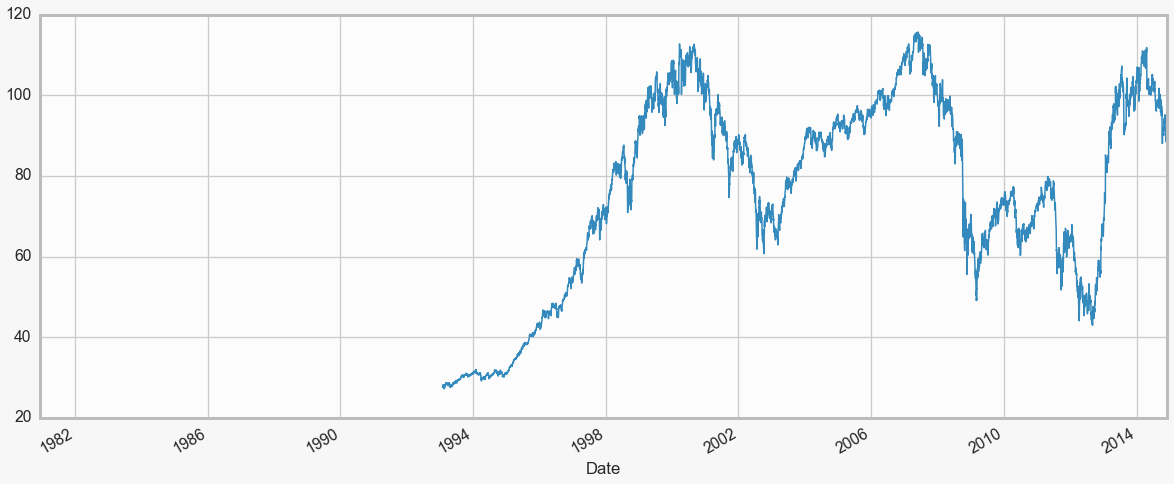

In [41]:
(SPY.AdjClose - AAPL.AdjClose).plot()

In [42]:
tl1 = [SPY.Close[0:10],AAPL.Close]

In [45]:
multiTimeseriesToDF(tl1,['SPY','AAPL'],asPctChange=True, dropNA=True).head(30)

,AAPL,SPY
Date,,
1993-02-01,0.029412,0.007055
1993-02-02,-0.016327,0.002034
1993-02-03,-0.004149,0.010600
1993-02-04,-0.008333,0.004240
1993-02-05,-0.037815,-0.000667
1993-02-08,-0.013100,0.000000
1993-02-09,0.006726,-0.006893
1993-02-10,-0.019866,0.001343
1993-02-11,-0.011300,0.004919


In [314]:
len(testStocksDict.keys())

10

In [39]:
def calcEqualWeightIndex_fromDict(tsDict, onlyGetDailyReturns=False, indexStartValue=100, startDate=None, endDate=None):
    mergedDF_pct = multiTimeseriesToDF_fromDict(tsDict, asPctChange=True, startDate=startDate, endDate=endDate, fillNAvalue=0)
    # print(mergedDF_pct.head(3))
    equalWeight_pct = mergedDF_pct.sum(axis=1) / len(tsDict.keys())

    if onlyGetDailyReturns:
        return equalWeight_pct
    else:
        return cum_returns(equalWeight_pct, withStartingValue=indexStartValue)
    
def calcEqualWeightIndex(tsList, tsNamesArr=None, onlyGetDailyReturns=False, indexStartValue=100):
    if tsNamesArr is None:
        inputNames = range(len(tsList))
    else:
        inputNames = tsNamesArr
    mergedDF_pct = multiTimeseriesToDF(tsList, inputNames, asPctChange=True, fillNAvalue=0)
    # print(mergedDF_pct.head(3))
    equalWeight_pct = mergedDF_pct.sum(axis=1) / len(tsList)
    if onlyGetDailyReturns:
        return equalWeight_pct
    else:
        return cum_returns(equalWeight_pct, withStartingValue=indexStartValue)

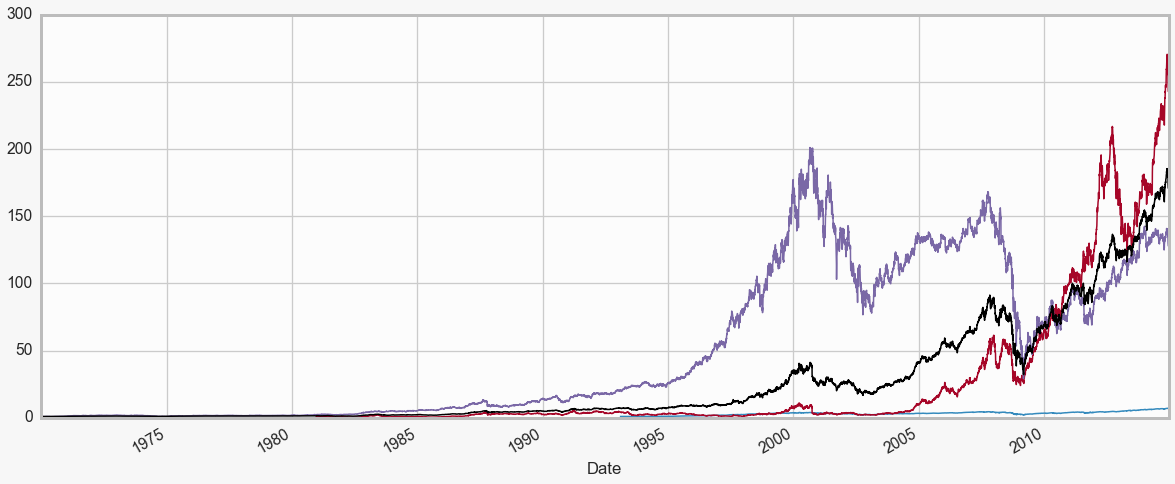

In [40]:
normalize(SPY.AdjClose).plot()
normalize(AAPL.AdjClose).plot()
normalize(GE.AdjClose).plot()
calcEqualWeightIndex([SPY.AdjClose,AAPL.AdjClose,GE.AdjClose],indexStartValue=1).plot(color='black')

In [41]:
def findBest_bootstrap(tsDict, seedPositionStr, numToSelect=5, detrend=False, applyABStoCorr=True, 
                       useCoint=False, autoLagStyle=None, maxLagDays=1 ):
    if len(tsDict.keys()) < numToSelect:
        numIter = len(tsDict.keys())-1
    else:
        numIter = numToSelect-1
    
    print( seedPositionStr)
    
    currPortDict = {}
    currPortDict[seedPositionStr] = tsDict.get(seedPositionStr).copy()
    
    seedPosition = tsDict.get(seedPositionStr).copy()
    seedPosition.name = seedPositionStr
    currPort = seedPosition
    
    remainingIdArr = np.setdiff1d( tsDict.keys(), currPortDict.keys() )
    
    print(remainingIdArr)

    for j in range(numIter):
        if useCoint:
            if detrend:
                # print("running ADF test with detrending")
                tempADF = [ (i, ts.adfuller( (detrendTS(tsDict.get(i))+detrendTS(currPort)).dropna().values, regression='ct',maxlag=maxLagDays, autolag=autoLagStyle)[1] ) for i in remainingIdArr ]
            else:
                # print("running ADF test with detrending")
                tempADF = [ (i, ts.adfuller( (tsDict.get(i)+currPort).dropna().values, regression='c',maxlag=maxLagDays, autolag=autoLagStyle)[1] ) for i in remainingIdArr ]
        else:
            if detrend:
                if applyABStoCorr:
                    tempADF = [ (i, abs( detrendTS(tsDict.get(i)).pct_change().dropna().corr(detrendTS(currPort).pct_change().dropna()) ) ) for i in remainingIdArr ]
                else:
                    tempADF = [ (i, detrendTS(tsDict.get(i)).pct_change().dropna().corr(detrendTS(currPort).pct_change().dropna()) ) for i in remainingIdArr ]
            else:
                if applyABStoCorr:
                    tempADF = [ (i, abs( tsDict.get(i).pct_change().dropna().corr(currPort.pct_change().dropna()) ) ) for i in remainingIdArr ]
                else:
                    tempADF = [ (i, tsDict.get(i).pct_change().dropna().corr(currPort.pct_change().dropna()) ) for i in remainingIdArr ]
        # print(tempADF)           
        tempADFdf = pd.DataFrame(tempADF)
        tempADFser = pd.Series(data=tempADFdf[1].values,index=tempADFdf[0].values)
        tempADFser.sort()
        print(tempADFser)
        print(tempADFser.index.values[0])
        print(tempADFser.values[0])
        newPositionStr = tempADFser.index[0]
        print( newPositionStr )
        
        newPosition = tsDict.get(newPositionStr).copy()
        newPosition.name = newPositionStr
        currPortDict[ newPositionStr ] = newPosition
        
        currPort = calcEqualWeightIndex( currPortDict.values(), currPortDict.keys(), indexStartValue=100 )
        remainingIdArr = np.setdiff1d( tsDict.keys(), currPortDict.keys() )
    print(currPortDict.keys())    
    return (currPortDict.keys(), currPort)

In [42]:
AAPL.AdjClose.size

8581

In [43]:
[ i for i in testStocksDict.keys() if testStocksDict.get(i).size > 8000 ]

['GE', 'IBM', 'AAPL', 'XOM']

SPY
['AAPL' 'GE' 'GLD' 'IBM' 'QID' 'SDS' 'SLV' 'USO' 'XOM']
QID     0.132090
SDS     0.212697
GLD     0.339050
IBM     0.548083
XOM     0.738390
SLV     0.823948
GE      0.870737
USO     0.906663
AAPL    0.996234
dtype: float64
QID
0.132089934694
QID
SDS     0.230367
SLV     0.313450
USO     0.630810
AAPL    0.678314
GLD     0.826418
IBM     0.853751
GE      0.946417
XOM     0.951139
dtype: float64
SDS
0.230367078474
SDS
AAPL    0.344307
SLV     0.435210
USO     0.585294
GLD     0.801361
IBM     0.806899
GE      0.930701
XOM     0.945641
dtype: float64
AAPL
0.344307099597
AAPL
IBM    0.839652
USO    0.862262
XOM    0.876290
GE     0.878195
SLV    0.885640
GLD    0.930268
dtype: float64
IBM
0.839651924674
IBM
['SPY', 'AAPL', 'SDS', 'IBM', 'QID']
sharpe ratio: 
0.474964290771
stability of timeseries: 
0.935411563004
Beta: 
0.205134289618
[('SPY', 0.56458037273005213), ('GE', 0.5217101917737792), ('IBM', 0.41007108374946749), ('SDS', -0.44718619449198288), ('USO', -0.22783937433345192), (

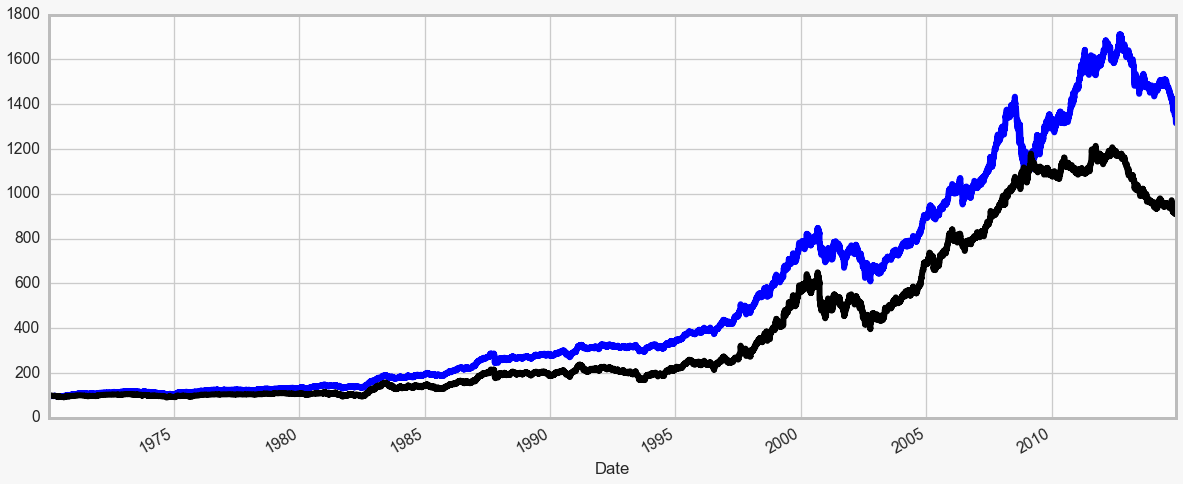

In [44]:
coint_bs = findBest_bootstrap(testStocksDict, 'SPY', numToSelect=5, detrend=True, applyABStoCorr=True, useCoint=True)
#normalize(multiTimeseriesToDF( testStocksDict.values(), testStocksDict.keys()),withStartingValue=100).plot()
print("sharpe ratio: ")
print(sharpeRatio(coint_bs[1]))
print("stability of timeseries: ")
print(stabilityOfTimeseries(coint_bs[1]))
print("Beta: ")
print(betaTimeseries(coint_bs[1],SPY.AdjClose))
print( [ (i , sharpeRatio(testStocksDict.get(i)) ) for i in testStocksDict.keys() ] )
print( [ (i , stabilityOfTimeseries(testStocksDict.get(i)) ) for i in testStocksDict.keys() ] )
calcEqualWeightIndex(testStocksDict.values()).plot(color='blue',linewidth=6)
coint_bs[1].plot(color='black', linewidth=6)

SPY
['AAPL' 'GE' 'GLD' 'IBM' 'QID' 'SDS' 'SLV' 'USO' 'XOM']
GE      0.000230
IBM     0.000595
AAPL    0.000625
XOM     0.000803
SDS     0.003052
QID     0.003147
GLD     0.003587
USO     0.006164
SLV     0.087858
dtype: float64
GE
0.000229900874222
GE
QID     0.000436
IBM     0.000839
XOM     0.002381
SDS     0.003428
AAPL    0.003880
USO     0.004513
GLD     0.005182
SLV     0.006420
dtype: float64
QID
0.000436258359164
QID
IBM     0.001410
USO     0.002098
SDS     0.002554
AAPL    0.003444
GLD     0.006233
SLV     0.008185
XOM     0.009372
dtype: float64
IBM
0.00140998195352
IBM
GLD     0.000219
SLV     0.000400
AAPL    0.000867
XOM     0.001209
SDS     0.003186
USO     0.004838
dtype: float64
GLD
0.000219479611323
GLD
['SPY', 'GE', 'GLD', 'IBM', 'QID']
sharpe ratio: 
0.548968121351
stability of timeseries: 
0.957219356032
Beta: 
0.416588147281
[('SPY', 0.56458037273005213), ('GE', 0.5217101917737792), ('IBM', 0.41007108374946749), ('SDS', -0.44718619449198288), ('USO', -0.2278393743

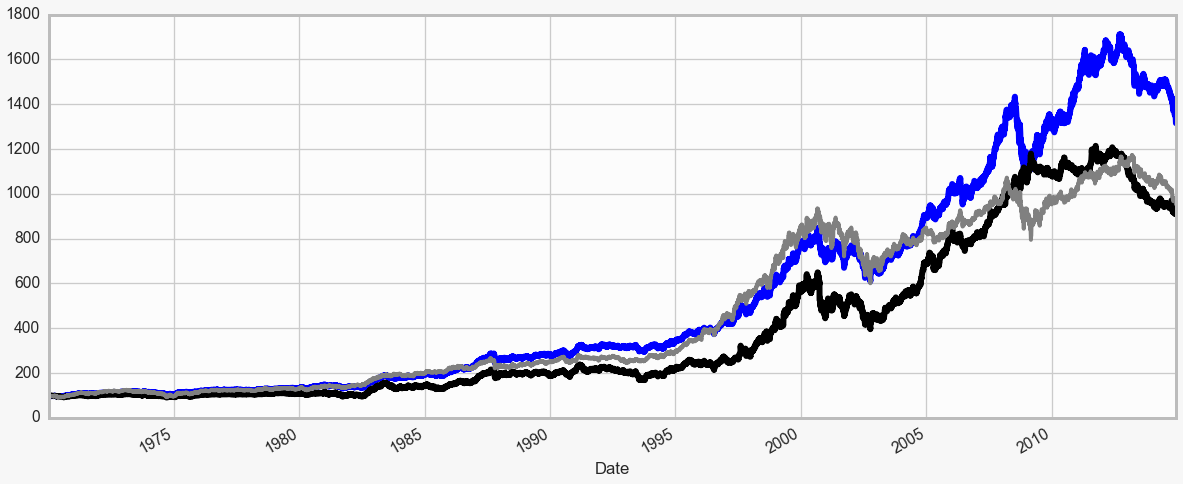

In [45]:
corr_bs = findBest_bootstrap(testStocksDict, 'SPY', numToSelect=5, detrend=True, applyABStoCorr=True, useCoint=False)
# normalize(multiTimeseriesToDF( testStocksDict.values(), testStocksDict.keys()),withStartingValue=100).plot()
print("sharpe ratio: ")
print(sharpeRatio(corr_bs[1]))
print("stability of timeseries: ")
print(stabilityOfTimeseries(corr_bs[1]))
print("Beta: ")
print(betaTimeseries(corr_bs[1],SPY.AdjClose))

print( [ (i , sharpeRatio(testStocksDict.get(i)) ) for i in testStocksDict.keys() ] )
print( [ (i , stabilityOfTimeseries(testStocksDict.get(i)) ) for i in testStocksDict.keys() ] )
calcEqualWeightIndex(testStocksDict.values()).plot(color='blue',linewidth=6)
coint_bs[1].plot(color='black', linewidth=6)
corr_bs[1].plot(color='gray', linewidth=4)

In [46]:
GE.tail()

GE,Open,High,Low,Close,Volume,AdjClose
Date,,,,,,
2014-12-15,25.02,25.03,24.41,24.59,63574000,24.36
2014-12-16,24.54,25.18,24.40,24.49,48388000,24.26
2014-12-17,24.61,24.72,24.06,24.66,77589300,24.43
2014-12-18,25.13,25.15,24.68,25.14,52044700,25.14
2014-12-19,25.12,25.70,25.00,25.62,86434700,25.62


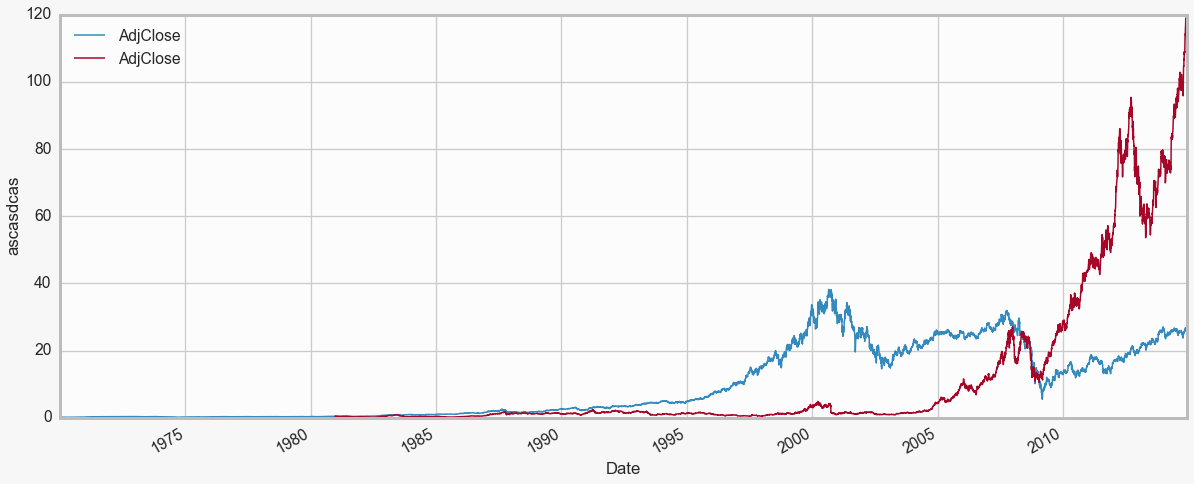

In [47]:
GE.AdjClose.plot()
AAPL.AdjClose.plot(legend=True).legend(loc='upper left')
plt.ylabel('ascasdcas')

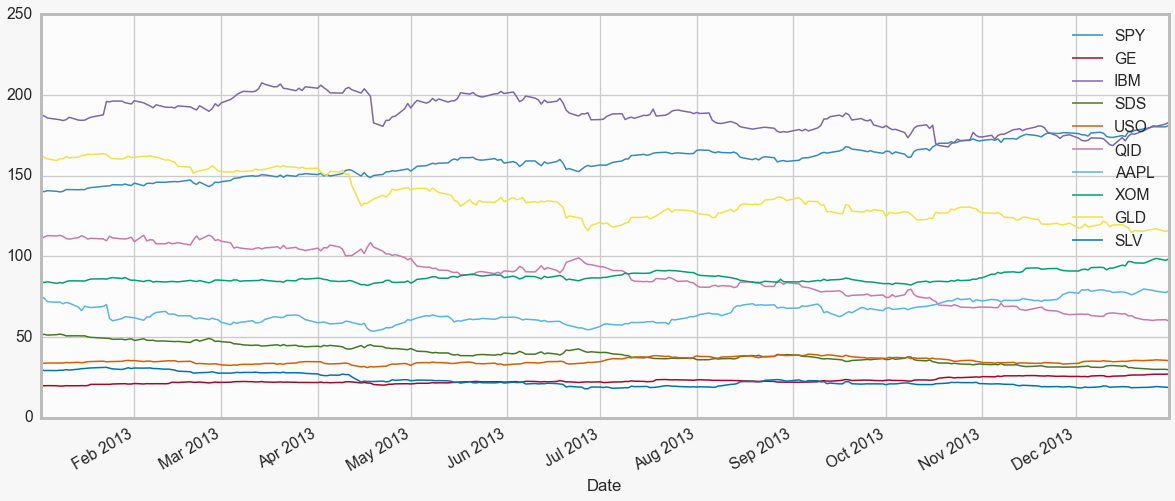

In [48]:
_=[ sliceTS(testStocksDict.get(i),'2013-1-1','2014-1-1').plot(legend=True,label=i) for i in testStocksDict.keys()]

In [49]:
AAPL.AdjClose[ (AAPL.AdjClose.index > pd.datetime(2015,1,1)) & (AAPL.AdjClose.index < pd.datetime(2016,1,1)) ].tail().size

0

In [50]:
def filterAndRank(tsInputDict, minDaysOfTrading=100, startDate=None, endDate=None,
                    useCumulativeHistoryForCalcs=True,
                    returnScore0to100=True,
                    score100isBest=True,
                    filterAnnualReturn = 0.01,
                    filterSharpeValue = 0.1,
                    filterAnnualVolatilityValue = 0.90,
                    filterStabilityValue = 0.01,
                    filterMaxDrawdownValue = -0.90,
                    filterOutLongOnly=False,
                    normalizeRanking=False ):
    # 'startDate' and 'endDate' should be of the form: pd.datetime(2015,1,1)
    #
    # this function first grabs only inputs that have been trading for more than 'minDaysOfTrading'
    # then it ranks each of them by the following metrics:
    #     - sharpeRatio
    #     - annualVolatility
    #     - annualReturn
    #     - maxDrawdown
    #     - stabilityOfTimeseries
    # Then all rankings for each are totaled (for now it just equally weights each metric's contribution)
    
    print str(len(tsInputDict.keys())) + '  : # of Inputs: '
    
    tsDict = {}
    
    if useCumulativeHistoryForCalcs:
        sliceStartDate = None
    else:
        sliceStartDate = startDate
    
    # slice the input timeseries if 'startDate' and 'endDate' are passed
    if (sliceStartDate is not None) or (endDate is not None):
        for i in tsInputDict.keys():
            tempTS = tsInputDict.get(i).copy()
            tempTS = sliceTS(tempTS, sliceStartDate, endDate)
            if tempTS.size > minDaysOfTrading:
                tsDict[i] = tempTS
        print str(len(tsDict.keys())) + '  : # of Inputs with data btwn startDate and endDate'
    else:
        tsDict = tsInputDict.copy()
    
    algosWithMinDays = [ i for i in tsDict.keys() if tsDict.get(i).size > minDaysOfTrading ]
    
    print str(len(algosWithMinDays)) + '   : with >' + str(minDaysOfTrading) + ' days history: '
    
    algosToKeep = np.array([],dtype='object')
    
    for i in tsDict.keys():
        tempNAV = tsDict.get(i)   
        # only keep algos that meet the minimum values declared in the function parameter list
        if tempNAV.size > minDaysOfTrading:                        # meets minimum days active
            if annualReturn(tempNAV) > filterAnnualReturn:     
                if sharpeRatio(tempNAV) > filterSharpeValue:
                    if annualVolatility(tempNAV) < filterAnnualVolatilityValue:
                        if stabilityOfTimeseries(tempNAV) > filterStabilityValue:
                            if maxDrawdown(tempNAV) > filterMaxDrawdownValue:
                                algosToKeep = np.append(algosToKeep, i)
    
    print str(algosToKeep.size) + '   : Those who pass quant filter criteria and move onto ranking algorithm: '
    if algosToKeep.size < 1:
        return {'ranks' : None, 'allRankInfo' : None, 'allInputsWithMinDay' : None }
    
    print '        (*these criteria also simply filtered out those whose account data still needs cleaning)  '
#    print '        Note: ' + str(algosToKeep.size-removeSectorClonesIDs(allAlgoDataDF,algosToKeep,byQuant=byQuant,correlCutoff=0.9).size) + ' have high-correlation to long/sector strategy'

    if filterOutLongOnly:
        # algosToKeep = removeSectorClonesIDs(allAlgoDataDF,algosToKeep,byQuant=byQuant,correlCutoff=0.9)
        print str(algosToKeep.size) + '   : Kept after filtering out Sector/Long only correlated: '
    
    # now try selecting the algos for the portfolio by ranking each of the algos that
    # passed the above filters by each of the filter metrics
    allSharpeRatio = [ ( i, sharpeRatio(tsDict.get(i))) for i in algosToKeep ]
    allAnnualVol = [ ( i, annualVolatility(tsDict.get(i))) for i in algosToKeep ]
    allAnnualRet = [ ( i, annualReturn(tsDict.get(i))) for i in algosToKeep ]
    allMaxDrawdown = [ ( i, maxDrawdown(tsDict.get(i))) for i in algosToKeep ]
    allStability = [ ( i, stabilityOfTimeseries(tsDict.get(i))) for i in algosToKeep ]

    sharpeRatioDict = dict(allSharpeRatio)
    rankingDF = pd.DataFrame.from_dict(sharpeRatioDict,orient='index')
    rankingDF = pd.merge(rankingDF, pd.DataFrame.from_dict(dict(allAnnualVol),orient='index'),left_index=True,right_index=True)
    rankingDF = pd.merge(rankingDF, pd.DataFrame.from_dict(dict(allAnnualRet),orient='index'),left_index=True,right_index=True)
    rankingDF = pd.merge(rankingDF, pd.DataFrame.from_dict(dict(allMaxDrawdown),orient='index'),left_index=True,right_index=True)
    rankingDF = pd.merge(rankingDF, pd.DataFrame.from_dict(dict(allStability),orient='index'),left_index=True,right_index=True)
    rankingDF.columns = ['sharpe','annVol','annRet','maxDD','stability']
    numOfMetrics = len(rankingDF.columns)

    print "numMetrics" + str(len(rankingDF.columns))
    
    if normalizeRanking:    
        rankingDF['rankSharpeRatio'] = rankingDF.sharpe.rank(ascending=False)
        rankingDF['rankSharpeRatio'] = rankingDF.rankSharpeRatio - rankingDF.rankSharpeRatio.mean()
        rankingDF['rankSharpeRatio'] = rankingDF.rankSharpeRatio / rankingDF.rankSharpeRatio.std()
        
        rankingDF['rankAnnVol'] = rankingDF.annVol.rank()
        rankingDF['rankAnnVol'] = rankingDF.rankAnnVol - rankingDF.rankAnnVol.mean()
        rankingDF['rankAnnVol'] = rankingDF.rankAnnVol / rankingDF.rankAnnVol.std()
        
        rankingDF['rankAnnRet'] = rankingDF.annRet.rank(ascending=False)
        rankingDF['rankAnnRet'] = rankingDF.rankAnnRet - rankingDF.rankAnnRet.mean()
        rankingDF['rankAnnRet'] = rankingDF.rankAnnRet / rankingDF.rankAnnRet.std()
        
        rankingDF['rankMaxDD'] = rankingDF.maxDD.rank(ascending=False)
        rankingDF['rankMaxDD'] = rankingDF.rankMaxDD - rankingDF.rankMaxDD.mean()
        rankingDF['rankMaxDD'] = rankingDF.rankMaxDD / rankingDF.rankMaxDD.std()
        
        rankingDF['rankStability'] = rankingDF.stability.rank(ascending=False)
        rankingDF['rankStability'] = rankingDF.rankStability - rankingDF.rankStability.mean()
        rankingDF['rankStability'] = rankingDF.rankStability / rankingDF.rankStability.std()
    else:
        rankingDF['rankSharpeRatio'] = rankingDF.sharpe.rank(ascending=False)
        rankingDF['rankAnnVol'] = rankingDF.annVol.rank()
        rankingDF['rankAnnRet'] = rankingDF.annRet.rank(ascending=False)
        rankingDF['rankMaxDD'] = rankingDF.maxDD.rank(ascending=False)
        rankingDF['rankStability'] = rankingDF.stability.rank(ascending=False)
    
    print rankingDF.shape
    rankingDF['rankRaw'] = (rankingDF.rankSharpeRatio + rankingDF.rankAnnVol + rankingDF.rankAnnRet + rankingDF.rankMaxDD + rankingDF.rankStability ) / numOfMetrics
    
    if returnScore0to100:
        rankingDF['rank_0_to_100'] = 100*( rankingDF['rankRaw'] / len(rankingDF['rankRaw']) )
        if score100isBest:
            rankingDF['rank_100_to_0'] = 100*( 1-rankingDF['rankRaw']/len(rankingDF['rankRaw']) )
            rankingDF = rankingDF.sort(columns='rank_100_to_0',ascending=False)
            rankingDF['rankFinal'] = rankingDF['rank_100_to_0']
        else:
            rankingDF = rankingDF.sort(columns='rank_0_to_100',ascending=True)
            rankingDF['rankFinal'] = rankingDF['rank_0_to_100']
    else:
        rankingDF = rankingDF.sort(columns='rankRaw',ascending=True)
        rankingDF['rankFinal'] = rankingDF['rankRaw']
            
    
        
    return {'ranks' : rankingDF['rankFinal'], 
            'allRankInfo' : rankingDF, 
            'allInputsWithMinDay' : algosWithMinDays }

In [51]:
[ testStocksDict.get(i).index[0] for i in testStocksDict.keys() ]

[Timestamp('1993-01-29 00:00:00'),
 Timestamp('1970-01-02 00:00:00'),
 Timestamp('1970-01-02 00:00:00'),
 Timestamp('2006-07-13 00:00:00'),
 Timestamp('2006-04-10 00:00:00'),
 Timestamp('2006-07-13 00:00:00'),
 Timestamp('1980-12-12 00:00:00'),
 Timestamp('1970-01-02 00:00:00'),
 Timestamp('2004-11-18 00:00:00'),
 Timestamp('2006-04-28 00:00:00')]

In [52]:
tFil = filterAndRank(testStocksDict,minDaysOfTrading=100,startDate=pd.datetime(2012,1,1),endDate=pd.datetime(2013,1,1))

10  : # of Inputs: 
10  : # of Inputs with data btwn startDate and endDate
10   : with >100 days history: 
7   : Those who pass quant filter criteria and move onto ranking algorithm: 
        (*these criteria also simply filtered out those whose account data still needs cleaning)  
numMetrics5
(7, 10)


In [53]:
tFil.get('allRankInfo')

,sharpe,annVol,annRet,maxDD,stability,rankSharpeRatio,rankAnnVol,rankAnnRet,rankMaxDD,rankStability,rankRaw,rank_0_to_100,rank_100_to_0,rankFinal
GLD,0.874050,0.207534,0.181395,-0.294141,0.967558,1,2,3,1,2,1.8,25.714286,74.285714,74.285714
XOM,0.675686,0.242846,0.164088,-0.416667,0.983086,2,3,4,2,1,2.4,34.285714,65.714286,65.714286
AAPL,0.573788,0.494255,0.283598,-0.817623,0.741028,3,7,1,6,5,4.4,62.857143,37.142857,37.142857
SPY,0.493142,0.196620,0.096961,-0.551855,0.656780,5,1,7,3,7,4.6,65.714286,34.285714,34.285714
GE,0.514100,0.293027,0.150645,-0.855273,0.910406,4,5,5,7,3,4.8,68.571429,31.428571,31.428571
SLV,0.490595,0.379632,0.186246,-0.570805,0.726106,6,6,2,4,6,4.8,68.571429,31.428571,31.428571
IBM,0.433804,0.264190,0.114606,-0.693981,0.899596,7,4,6,5,4,5.2,74.285714,25.714286,25.714286


In [54]:
def buildPortfolio_walkForward(tsDict, combineMethod='rank', numToSelect=5, minDaysOfTrading=100,
                               startDate=pd.datetime(2013,6,1), endDate=pd.datetime(2014,12,1), portRebalDays=90,
                               useCumulativeHistoryForCalcs=True, filterCriteriaDict=None ):
    # 'combineMethod' :  
    #       'rank' : just equal weight rank all inputs and take Top N to build portfolio
    #       'correl' : take all inputs that pass filters and take the N least correlated. Starting with highest ranked one
    #       'coint' : take all inputs that pass filters and take the N best cointegrated. Starting with highest ranked one
    
    if filterCriteriaDict is None:
        filterValuesDict = {'AnnualReturn' : -0.99,
                             'SharpeValue' : -10.0,
                             'AnnualVolatility' : 1.99,
                             'Stability' : 0.00,
                             'MaxDrawdown' : -0.99,
                             'Normalize' : False,
                             'FilterOutLongOnly' : False}
    else:
        filterValuesDict = filterCriteriaDict
         
    tempStartDate = startDate
    tempEndDate = tempStartDate + timedelta(portRebalDays)
    count = 0
    wfDict = {}
    while tempEndDate < endDate:
        if useCumulativeHistoryForCalcs is None:
            tempStartDate = None
        print 'Computing Ranks on date:' + str(tempEndDate)
        tempRanked = filterAndRank(tsDict, minDaysOfTrading=minDaysOfTrading, startDate=tempStartDate, endDate=tempEndDate,
                                   useCumulativeHistoryForCalcs=useCumulativeHistoryForCalcs ,
                                   filterAnnualReturn=filterValuesDict.get('AnnualReturn') ,
                                   filterSharpeValue=filterValuesDict.get('SharpeValue') ,
                                   filterAnnualVolatilityValue=filterValuesDict.get('AnnualVolatility') ,
                                   filterStabilityValue=filterValuesDict.get('Stability') ,
                                   filterMaxDrawdownValue=filterValuesDict.get('MaxDrawdown') ,
                                   normalizeRanking=filterValuesDict.get('Normalize') ,
                                   filterOutLongOnly=filterValuesDict.get('FilterOutLongOnly') )
        
        
        
        selDict = {}
        # selDict['start'] = tempStartDate
        selDict['rankingDate'] = tempEndDate
        if tempRanked.get('ranks') is None:
            pass # selDict['holdingsID'] = []
            # selDict['holdingsTS'] = []
        else:
            if len(tempRanked.get('ranks')) < numToSelect:
                lastSel = len(tempRanked)
            else:
                lastSel = numToSelect
            print "num to select:" + str(lastSel)

            selDict['holdingsID'] = tempRanked.get('ranks').index.values[0:lastSel]
            tempFutureHoldingsData = {}
            tempHoldingsData = {}
            # now calc the equal weight index of these holdings over the future period
            futureEndDate = tempEndDate + timedelta(portRebalDays)
            for i in selDict['holdingsID']:
                # print(i)
                tempFutureHoldingsData[i] = sliceTS(tsDict.get(i),startDate=tempEndDate, endDate=futureEndDate)
                tempHoldingsData[i] = tsDict.get(i)
            selDict['futurePeriod_holdingsData'] = pd.DataFrame.from_dict(tempFutureHoldingsData)
            selDict['eqPort'] = calcEqualWeightIndex_fromDict(tempHoldingsData, indexStartValue=100,
                                                              startDate=tempEndDate, endDate=futureEndDate)
          #  selDict['eqWeightPort'] = selDict['eqWeightPort'].reindex(index=selDict['eqWeightPort'].index.normalize())
            selDict['eqPort_start'] = selDict['eqPort'].index[0]
            selDict['eqPort_end'] = selDict['eqPort'].index[-1]
            selDict['p_eqSharpe'] = sharpeRatio(selDict['eqPort'] )
            selDict['p_eqAnnRet'] = annualReturn(selDict['eqPort'] )
            selDict['p_eqAnnVol'] = annualVolatility(selDict['eqPort'] )
            selDict['p_eqStab'] = stabilityOfTimeseries(selDict['eqPort'] )
            selDict['p_maxDD'] = maxDrawdown(selDict['eqPort'] )
            selDict['p_TR'] = (selDict['eqPort'].iloc[-1] - 100) / 100
            
        wfDict[count] = selDict
        
        tempStartDate = tempEndDate
        tempEndDate = tempEndDate + timedelta(portRebalDays)
        count = count + 1
        
    if combineMethod == 'rank':
        # build the rebalanced portfolio based on the rankings determined above
        t = 5
        
    
    return { 'rebalances' : pd.DataFrame(wfDict).T }

In [55]:
SPY.AdjClose.tail()

Date
2014-12-15    198.41
2014-12-16    196.82
2014-12-17    200.68
2014-12-18    205.64
2014-12-19    206.52
Name: AdjClose, dtype: float64

In [56]:
twf_port = buildPortfolio_walkForward(testStocksDict,numToSelect=3,minDaysOfTrading=100,startDate=pd.datetime(2003,1,1))

Computing Ranks on date:2003-04-01 00:00:00
10  : # of Inputs: 
5  : # of Inputs with data btwn startDate and endDate
5   : with >100 days history: 
5   : Those who pass quant filter criteria and move onto ranking algorithm: 
        (*these criteria also simply filtered out those whose account data still needs cleaning)  
numMetrics5
(5, 10)
num to select:3
Computing Ranks on date:2003-06-30 00:00:00
10  : # of Inputs: 
5  : # of Inputs with data btwn startDate and endDate
5   : with >100 days history: 
5   : Those who pass quant filter criteria and move onto ranking algorithm: 
        (*these criteria also simply filtered out those whose account data still needs cleaning)  
numMetrics5
(5, 10)
num to select:3
Computing Ranks on date:2003-09-28 00:00:00
10  : # of Inputs: 
5  : # of Inputs with data btwn startDate and endDate
5   : with >100 days history: 
5   : Those who pass quant filter criteria and move onto ranking algorithm: 
        (*these criteria also simply filtered out th

In [57]:
twf_port.get('rebalances').head()

,eqPort,eqPort_end,eqPort_start,futurePeriod_holdingsData,holdingsID,p_TR,p_eqAnnRet,p_eqAnnVol,p_eqSharpe,p_eqStab,p_maxDD,rankingDate
0,Date 2003-04-02 102.032005 2003-04-03 10...,2003-06-27 00:00:00,2003-04-02 00:00:00,GE SPY XOM Date ...,"[XOM, GE, SPY]",0.08988193,0.2884709,0.1518538,1.899662,0.7882328,-0.05582738,2003-04-01 00:00:00
1,Date 2003-07-01 100.507889 2003-07-02 10...,2003-09-26 00:00:00,2003-07-01 00:00:00,GE SPY XOM Date ...,"[XOM, GE, SPY]",0.03658874,0.1377545,0.1441283,0.9557775,0.7138561,-0.04000359,2003-06-30 00:00:00
2,Date 2003-09-29 101.106142 2003-09-30 9...,2003-12-26 00:00:00,2003-09-29 00:00:00,GE SPY XOM Date ...,"[XOM, GE, SPY]",0.0767147,0.2627639,0.1186764,2.214121,0.1874206,-0.05072104,2003-09-28 00:00:00
3,Date 2003-12-29 101.227854 2003-12-30 10...,2004-03-25 00:00:00,2003-12-29 00:00:00,GE SPY XOM Date ...,"[XOM, SPY, GE]",0.002661502,-0.03029395,0.1411313,-0.2146509,0.0008532885,-0.0741345,2003-12-27 00:00:00
4,Date 2004-03-29 101.166294 2004-03-30 10...,2004-06-23 00:00:00,2004-03-29 00:00:00,GE SPY XOM Date ...,"[XOM, SPY, GE]",0.09026726,0.3270339,0.1212793,2.696535,0.3165257,-0.04214876,2004-03-26 00:00:00


In [58]:
twf_port.get('rebalances').iloc[0]['futurePeriod_holdingsData'].get('SPY').head(3)

Date
2003-04-02    69.78
2003-04-03    69.45
2003-04-04    69.86
Name: SPY, dtype: float64

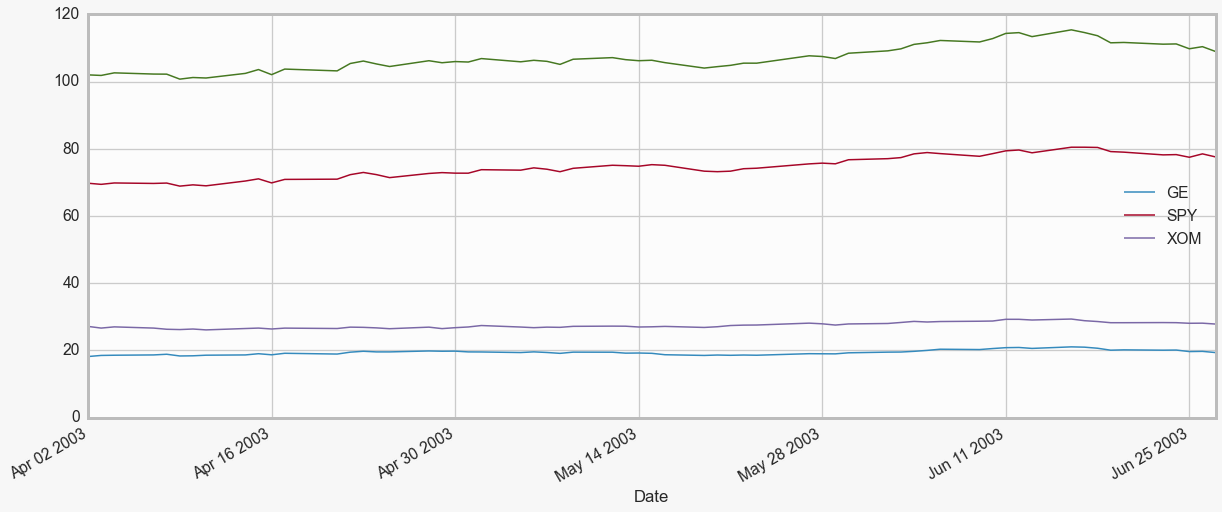

In [59]:
twf_port.get('rebalances').iloc[0]['futurePeriod_holdingsData'].plot()
tempts = twf_port.get('rebalances').iloc[0]['eqPort']
tempts.plot()

In [60]:
tempts.head().index[0]

Timestamp('2003-04-02 00:00:00')

In [61]:
tempts.tail()

Date
2003-06-23    111.165313
2003-06-24    111.237722
2003-06-25    109.798714
2003-06-26    110.426285
2003-06-27    108.988193
dtype: float64

In [62]:
twf_port.get('rebalances').iloc[0]['eqWeightPort_end']

KeyError: 'eqWeightPort_end'

In [63]:
twf_port.get('rebalances').iloc[0]['eqWeightPort_start']

KeyError: 'eqWeightPort_start'

In [64]:
numpy.__version__

'1.9.1'

In [65]:
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB

In [66]:
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d" % (iris.data.shape[0],(iris.target != y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [67]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [68]:
gnb

GaussianNB()

In [69]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

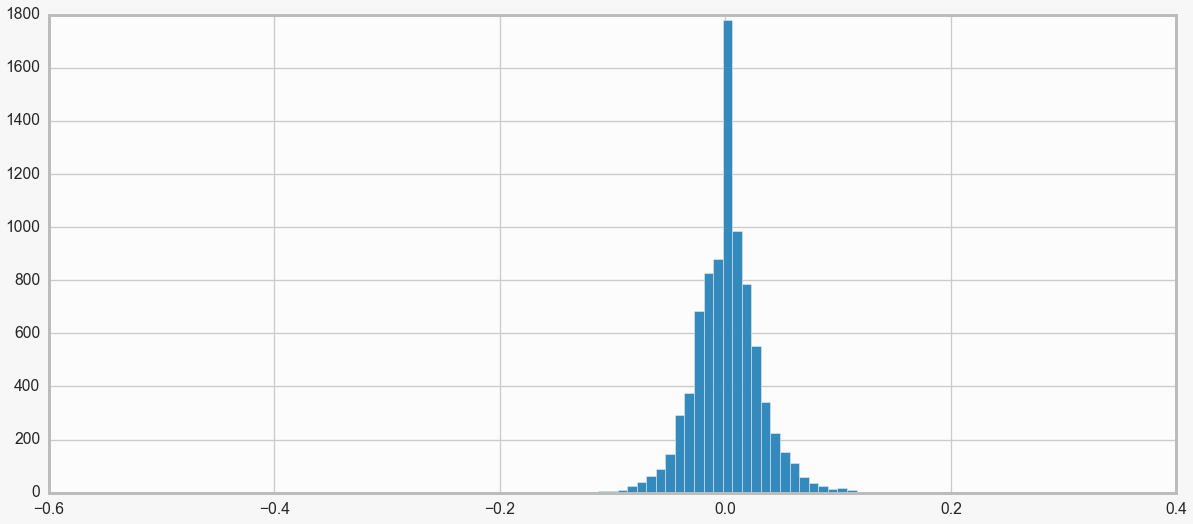

In [70]:
_=plt.hist(AAPL.AdjClose.pct_change().dropna(),bins=100)